# Load functions and find building ranges

This step is needed for both extracting the building info and for visualizing player trajectory from log data

To find the range of building, go to https://pessimistress.github.io/minecraft/ and drag in .mca files in the region folder to find the regions and chunks that contain the building
* bottom left block -> (x_low, z_high)
* top right block -> (x_high, z_low)

If your find the building in an .mca file named `r.-5.0.mca`, then the region indices are the two numbers separated by periods, i.e., -5 and 0. Thus the region is (-5,0)
        
If the building is encoded in multiple .mca files, run this code multiple times with different output sub folder names, then use Tool A-2 to merge the PNG, JSON, and CSV files.

In [40]:
## pip3 install nbtlib
import map_generator as mg

world_name = 'Saturn_Feb4' ## 'Falcon v1.02' ## name of the Minecraft world folder in input/worlds/
region = (-5,0) ## name of the .mca file where you can find the building

building_ranges = { ## x_low, x_high, z_low, z_high, y_low, y_high
    'Singleplayer': (-2192, -2129, 144, 191, 28, 30),
    'Sparky v3.03': (-2176, -2097, 144, 207, 52, 54),
#     'Saturn_Feb4': (-2240, -2065, -96, -1, 22, 25), # r.-5.-1.mca
    'Saturn_Feb4': (-2240, -2065, 1, 143, 22, 25), # r.-5.0.mca
#     'Falcon v1.02': (-2112, -2049, 128, 207, 60, 62)   # r.-5.0.mca
#     'Falcon v1.02': (-2048, -2017, 128, 207, 60, 62)   # r.-4.0.mca
}
ranges = building_ranges[world_name]

# Tool A - Generate map images, json, and csv

The outputs include three parts:
* images of the 2D floor plans on different levels of the region of interest at `outputs/*_map.png` where * = 0,1,2,9 (9 means a summary of floor 0 and 1, including victims, doors, signage, switches, etc.)
* a json file specifying the block type of all blocks within the region of interest at `outputs/blocks_in_building.json`
* a csv file that represent the region of interest that can be used as input to our gridworld framework at `outputs/darpa_maze.csv`

Input world: name of a world folder in Minecraft saves, can be found in
* /User/.minecraft/saves/
* /Users/USER_NAME/Library/Application\ Support/minecraft/saves/
* MalmoPlatform/Minecraft/run/saves/ (if using Malmo)

In [41]:
import sys
sys.path.append('MCWorldlib.egg')
import mcworldlib as mc
from os.path import join

## load the world folder, which takes a while but only need to do it once
world = mc.load(join('inputs', 'worlds', world_name))

Loading World 'Saturn_Feb4': 100%|██████████| 13/13 [00:01<00:00,  6.76 Region/s]


20 30 0 8 6 9


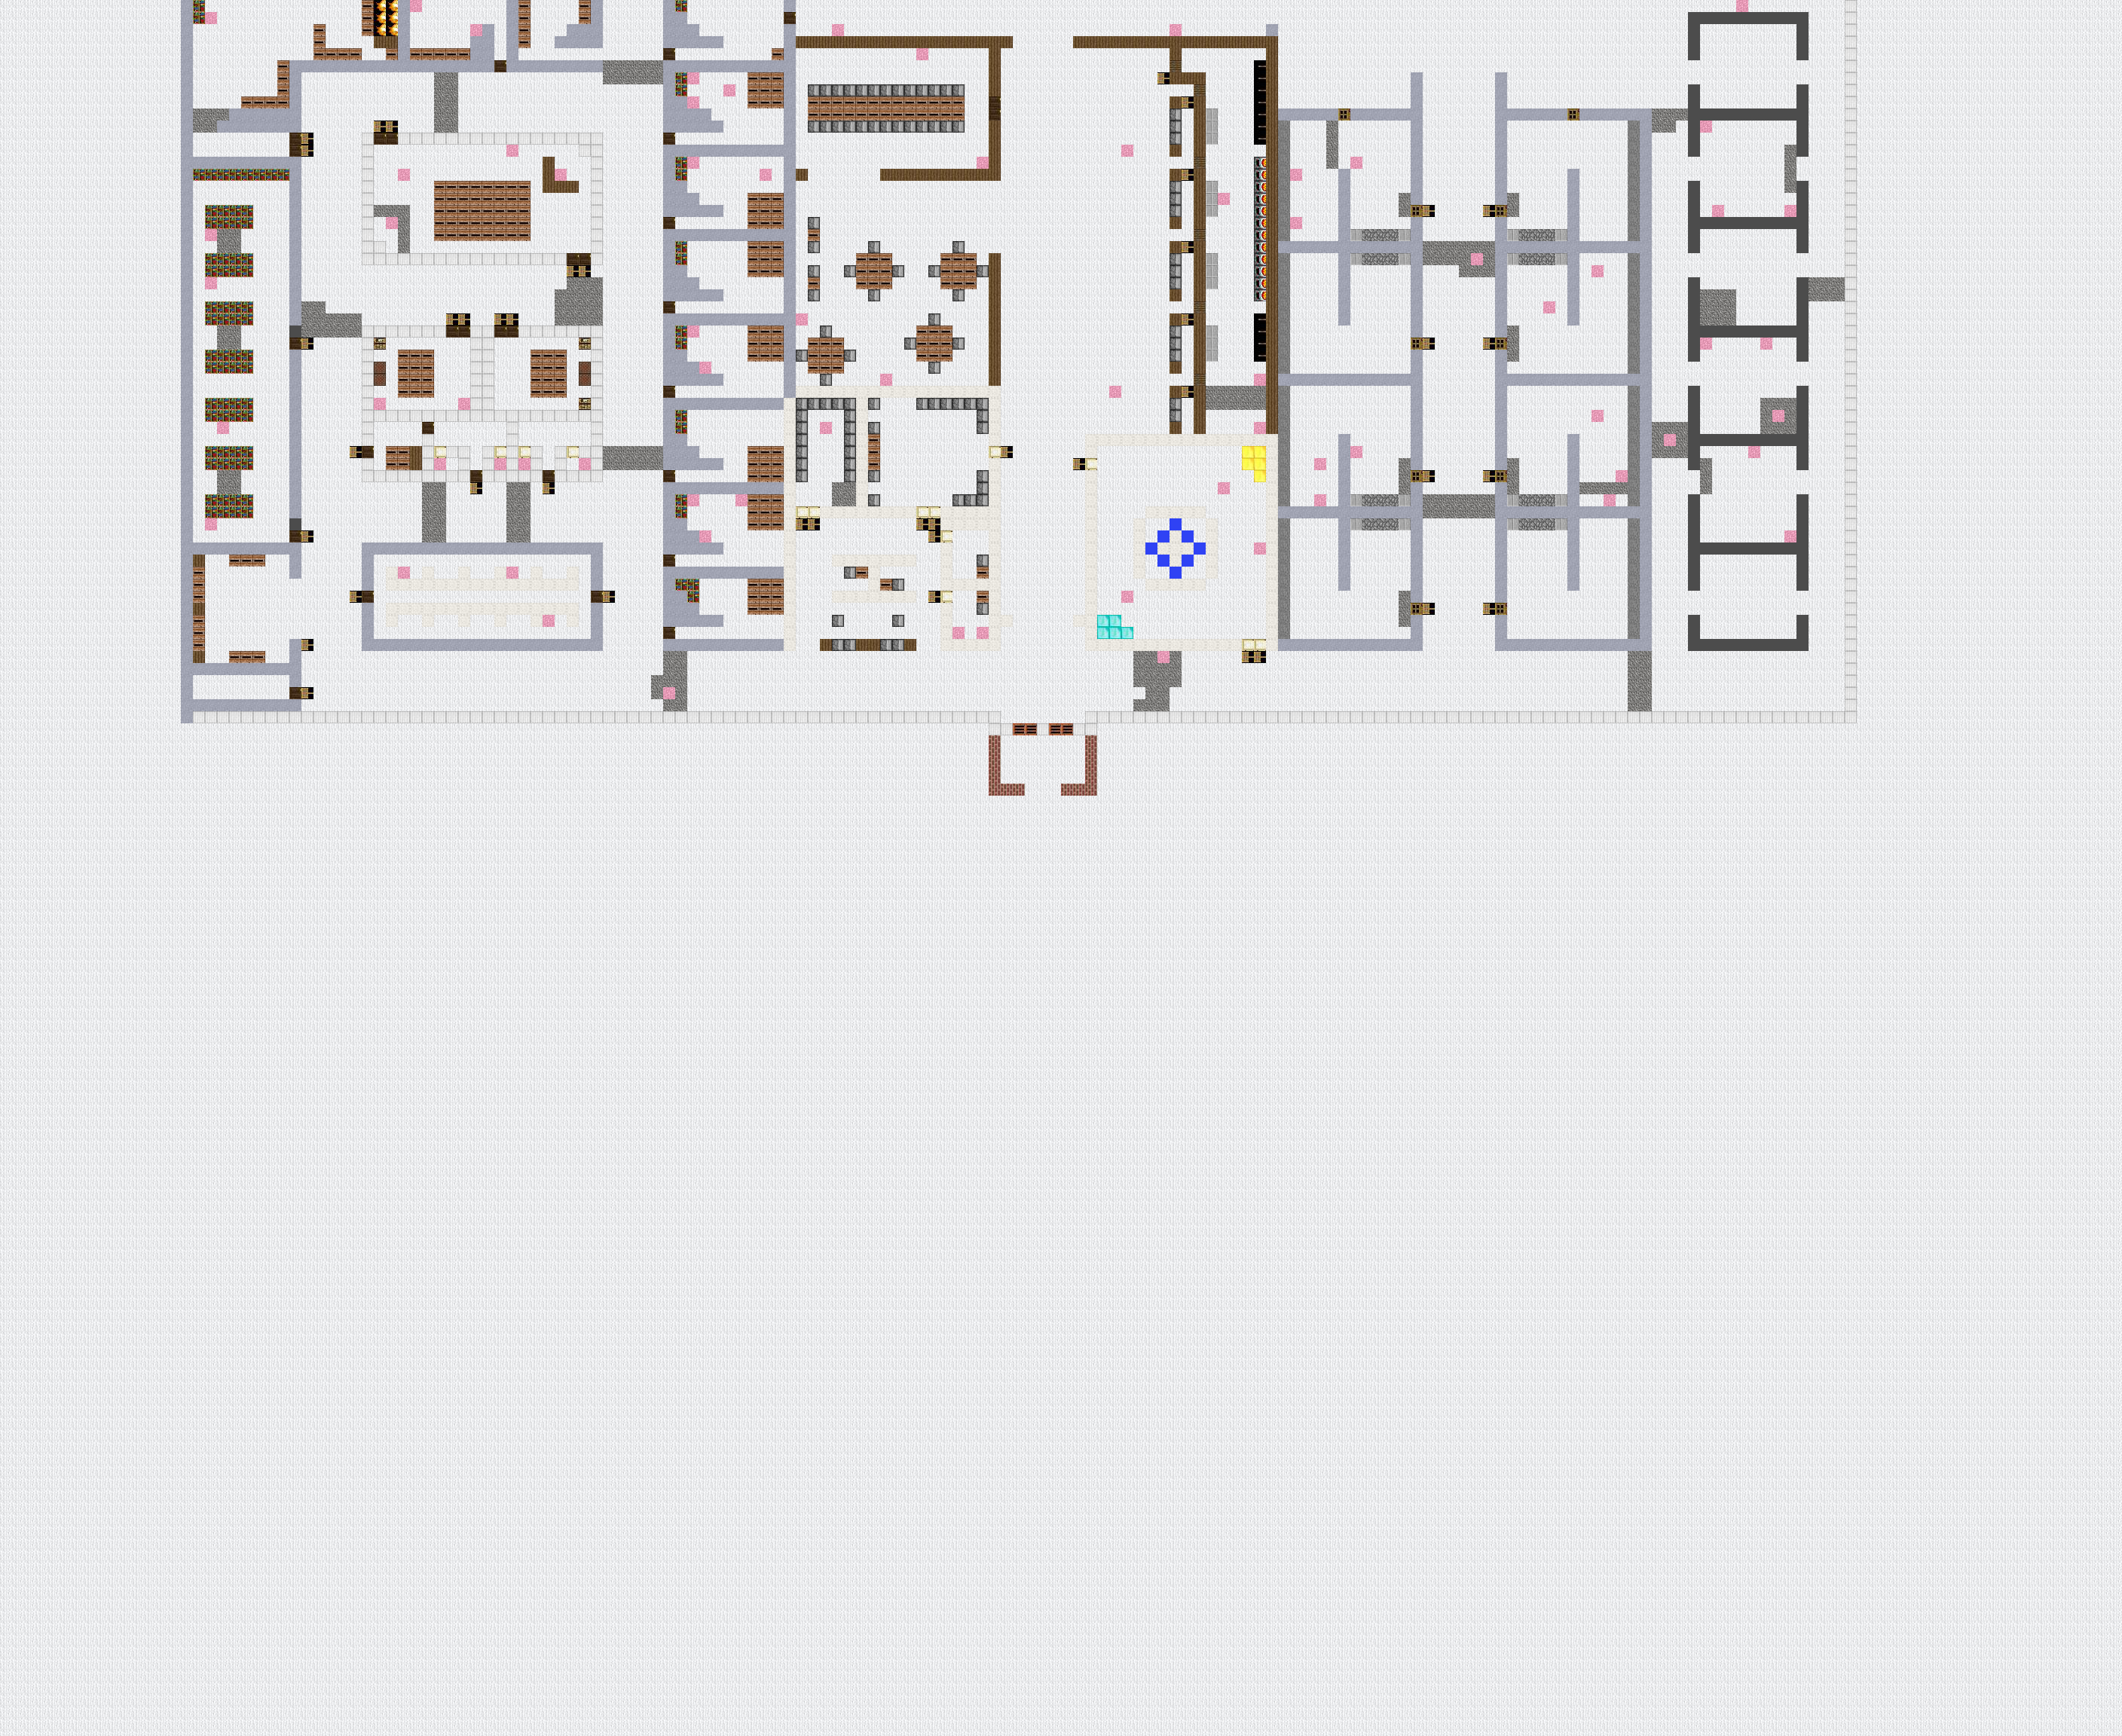

In [42]:
import map_generator as mg

all_blocks, important_blocks = mg.generate_maps(world, region, ranges)
mg.generate_json(all_blocks, ranges)
mg.generate_csv(important_blocks, ranges)

## Tool A-2 - Merge png/json in multiple regions

In the case of Falcon, the building is found in both region (-4,0) and (-5,0). Thus we need to concat the images of the map together, as well as generate one single file for 'blocks_in_building.json'

Here I put all my past outputs as subfolders in a folder named "_old" in "outputs"

In [43]:
import map_generator as mg
from os.path import join

folder1 = join('outputs','_old','210218 Saturn -5.-1')
folder2 = join('outputs','_old','210218 Saturn -5.0')

## generate '*_map.png' and 'blocks_in_building.json' in output folder
mg.merge_folders(folder1, folder2)

number of blocks 67584 101376 168960


In [1]:
import map_generator as mg
from os.path import join

folder1 = join('outputs','_old','200617 Falcon -5.0')
folder2 = join('outputs','_old','200617 Falcon -4.0')

## generate '*_map.png' and 'blocks_in_building.json' in output folder
mg.merge_folders(folder1, folder2)

number of blocks 15360 7680 23040


# Tool B: Generate traces from data stream

In [1]:
import trace_generator as tg
from os.path import join

world_name = 'Falcon v1.02'

## here we make a subfolder named 'Hackathon/' in both 'input/trajectories/' and 'output_trajectory/' 
data_name = join('Hackathon', 'ASIST_data_study_id_000001_condition_id_000005_trial_id_000015_messages.json')

player_name = 'ASU_MC' # for trial id 8-15;    # 'K_Fuse' for trial id 1-7
count_gap = 5
ranges = { ## x_low, x_high, z_low, z_high, y_low, y_high
    'Singleplayer': (-2192, -2129, 144, 191, 28, 30),
    'Sparky v3.03': (-2176, -2097, 144, 207, 52, 54),
    'Falcon v1.02': (-2112, -2017, 128, 207, 60, 62)   # the whole Falcon building for visualizing trajectories
}[world_name]
text_margin = {
    'Singleplayer': (830,20),
    'Sparky v3.03': (1120,20),
    'Falcon v1.02': (1370,540)
}[world_name]

steps = tg.read_data(data_name, player_name, count_gap, ranges)
tg.generate_mp4(steps, text_margin, ranges)

1213
